# TweetMine: text mining tweets

An experimental notebook that retrieves tweets and analyzes it. The example below uses Donald Trump's tweets.

### Load tweets into a json file

In [2]:
import tweepy
import config 
import json
from tweepy import OAuthHandler

auth = OAuthHandler(config.consumer_key,config.consumer_secret)
auth.set_access_token(config.access_token,config.access_secret)
api = tweepy.API(auth)

num_tweets = 2000                    # number of tweets to retrieve
twitter_id = 'realDonaldTrump'     # userid 

file_name = 'trumptweets.json'
output = open(file_name,"w")
for tweet in tweepy.Cursor(api.user_timeline, id=twitter_id).items(num_tweets):
    output.write(json.dumps(tweet._json)+'\n') 
output.close()


### Parse json into a dataframe

In [3]:
import json
import pandas as pd 

def load_tweets(file):
    with open(file,'r') as f:
        tweets = (json.loads(line) for i, line in enumerate(f.readlines()))
    return tweets

# Select the attributes needed
data = {'text': [], 'created_at': [], 'retweet_count': [], 'favorite_count': [], 'followers_count': []}
        
tweets = load_tweets(file_name)
for t in tweets:
    data['text'].append(t['text'])
    data['retweet_count'].append(t['retweet_count'])
    data['created_at'].append(t['created_at'])
    data['favorite_count'].append(t['favorite_count'])
    data['followers_count'].append(t['user']['followers_count'])
    
df = pd.DataFrame(data)
df['created_at'] = pd.to_datetime(df['created_at']) # convert to datetime data type
df.sort_values(by='created_at'); # suppress output (works in notebook)

### Looking at Favorite and Retweet Counts

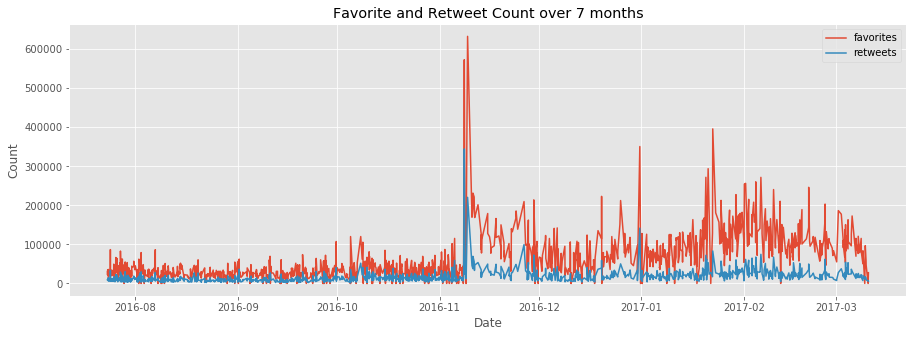

In [4]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize = (15,5))
num_days = (max(df['created_at']) - min(df['created_at'])).days
num_months = int(num_days/30)
plt.title('Favorite and Retweet Count over ' + str(num_months) + ' months')
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(df['created_at'],df['favorite_count'],label='favorite count')
plt.plot(df['created_at'],df['retweet_count'],label='retweet count')
plt.legend(['favorites','retweets'])
plt.show()

In [53]:
# max_favorite_count = max(df['favorite_count'])
# most_favorited_tweet = df.ix[df['favorite_count'].idxmax()]['text']

top_ten_tweets = df['favorite_count'].sort_values(ascending=False).head(10) # returns a df with first column = index, second column = tweet

print(twitter_id + "'s top 10 tweets (using favorite count)" + "\n")
for i in range(10):
    index = top_ten_tweets.index[i]
    print(str(i+1) + ")" + df.ix[index]['text'])
    print("Favorite count: " + str(df.ix[index]['favorite_count']) + "\n")


realDonaldTrump's top 10 tweets (using favorite count)

1)Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before
Favorite count: 632885

2)TODAY WE MAKE AMERICA GREAT AGAIN!
Favorite count: 573019

3)Peaceful protests are a hallmark of our democracy. Even if I don't always agree, I recognize the rights of people to express their views.
Favorite count: 395846

4)Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!
Favorite count: 350634

5)THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4
Favorite count: 293910

6)It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!
Favorite count: 271907

7)What an amazing comeback and win by the Patriots. Tom Brady, Bob Kraft and Coach B are total

### Word Frequency

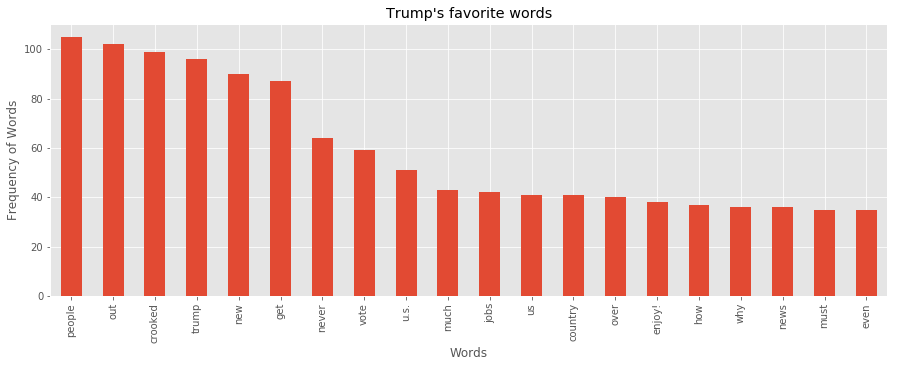

In [7]:
word_series = pd.Series(' '.join(df['text']).lower().split()) 
stop_words = ['the','is','of','at','to','be','and','in','a','will','for','on','with','i','you','we','our','my','it',
              '-','by','me','not','just','rt','so','very','she','from','who','her','but','no','or','he','up','would','should',
              'do']
filt  = list(filter(lambda word: not any(s in word for s in stop_words), word_series)) # filter stop words

plt.figure(figsize=(15,5))
plt.title("Trump's favorite words")

N = 20
word_freq = pd.Series(filt).value_counts()[:N]           # top N words
word_freq.plot(kind='bar')                               # how to rotate ticks?
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.show()

### Account Activity

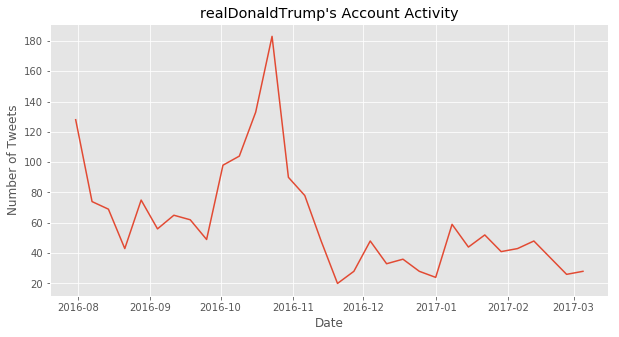

In [8]:
ind_df = df.set_index('created_at') 
ind_df = ind_df.groupby(pd.TimeGrouper(freq='W')).count().loc[:,'text'] # group by weeks, count, and extract a series
trim_df = ind_df.ix[1:len(ind_df)-1] # trim first/last week to ensure we show data collected from full weeks

plt.figure(figsize=(10,5))
plt.title(twitter_id + "'s Account Activity")
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.plot(trim_df)
plt.show()